In [32]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


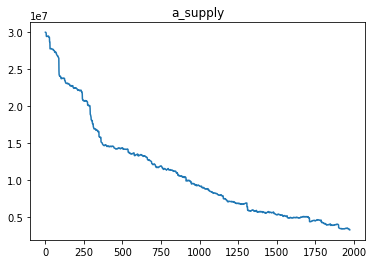

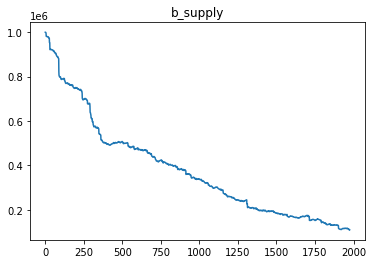

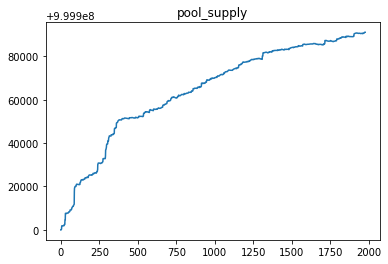

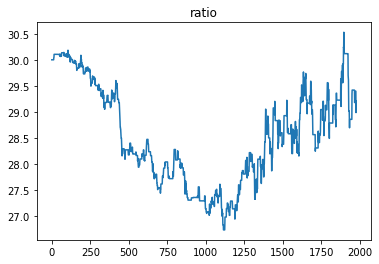

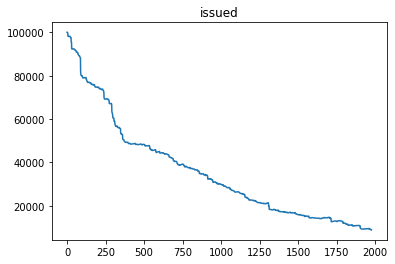

In [83]:
from constant_product_amm import Simulator

sim = Simulator()
sim.run_mix(num=1000)
states = sim.get_states()
for k, v in states.items():
    plt.title(k)
    plt.plot(v)
    plt.show()